In [1]:
import torch.utils.data as data
from config import LoadConfig, load_data_transformers
import pandas as pd
import os
from torch.utils.data import DataLoader
from PIL import Image
from PIL import ImageStat
import matplotlib.pyplot as plt
import torch

In [2]:
anno = pd.read_csv(os.path.join('datasets/CHAM/anno', 'ct_train.txt'),\
                                           sep="\t",\
                                           header=None,\
                                           names=['ImageName', 'label'],encoding='utf-8')

In [3]:
class dataset(data.Dataset):
    def __init__(self, anno, swap_size=[5,5], common_aug=None, swap=None, totensor=None, train=False, train_val=False, test=False):
        self.root_path = 'datasets/CHAM/data/'
        self.numcls = 53
        self.dataset = 'Cham'
        self.use_cls_2 = True
        self.use_cls_mul = False
        if isinstance(anno, pd.core.frame.DataFrame):
            self.paths = anno['ImageName'].tolist()
            self.labels = anno['label'].tolist()
        elif isinstance(anno, dict):
            self.paths = anno['img_name']
            self.labels = anno['label']

        if train_val:
            self.paths, self.labels = random_sample(self.paths, self.labels)
        self.common_aug = common_aug
        self.swap = swap
        self.totensor = totensor
        self.train = train
        self.swap_size = swap_size
        self.test = test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, item):
        img_path = os.path.join(self.root_path, self.paths[item])
        img = self.pil_loader(img_path)
        if self.test:
            img = self.totensor(img)
            label = self.labels[item]
            return img, label, self.paths[item]
        img_unswap = self.common_aug(img) if not self.common_aug is None else img
        plt.imshow(img_unswap)
        plt.show()
        image_unswap_list = self.crop_image(img_unswap, self.swap_size)

        swap_range = self.swap_size[0] * self.swap_size[1]
        swap_law1 = [(i-(swap_range//2))/swap_range for i in range(swap_range)]

        if self.train:
            img_swap = self.swap(img_unswap)
            image_swap_list = self.crop_image(img_swap, self.swap_size)
            unswap_stats = [sum(ImageStat.Stat(im).mean) for im in image_unswap_list]
            swap_stats = [sum(ImageStat.Stat(im).mean) for im in image_swap_list]
            swap_law2 = []
            for swap_im in swap_stats:
                distance = [abs(swap_im - unswap_im) for unswap_im in unswap_stats]
                index = distance.index(min(distance))
                swap_law2.append((index-(swap_range//2))/swap_range)
            plt.imshow(img_unswap)
            plt.show()
            img_swap = self.totensor(img_swap)
            label = self.labels[item]
            if self.use_cls_mul:
                label_swap = label + self.numcls
            if self.use_cls_2:
                label_swap = -1
            img_unswap = self.totensor(img_unswap)
            return img_unswap, img_swap, label, label_swap, swap_law1, swap_law2, self.paths[item]
        else:
            label = self.labels[item]
            swap_law2 = [(i-(swap_range//2))/swap_range for i in range(swap_range)]
            label_swap = label
            img_unswap = self.totensor(img_unswap)
            return img_unswap, label, label_swap, swap_law1, swap_law2, self.paths[item]

    def pil_loader(self,imgpath):
        with open(imgpath, 'rb') as f:
            with Image.open(f) as img:
                return img.convert('RGB')

    def crop_image(self, image, cropnum):
        width, high = image.size
        crop_x = [int((width / cropnum[0]) * i) for i in range(cropnum[0] + 1)]
        crop_y = [int((high / cropnum[1]) * i) for i in range(cropnum[1] + 1)]
        im_list = []
        for j in range(len(crop_y) - 1):
            for i in range(len(crop_x) - 1):
                im_list.append(image.crop((crop_x[i], crop_y[j], min(crop_x[i + 1], width), min(crop_y[j + 1], high))))
        return im_list


    def get_weighted_sampler(self):
        img_nums = len(self.labels)
        weights = [self.labels.count(x) for x in range(self.numcls)]
        return torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=img_nums)

In [4]:
transformers = load_data_transformers()
print(transformers['common_aug'])
# inital dataloader
train_set = dataset(anno = anno,
                    common_aug = transformers["common_aug"],\
                    swap = transformers["swap"],\
                    totensor = transformers["train_totensor"],\
                    train = True)

Compose(
    Resize(size=(192, 192), interpolation=PIL.Image.BILINEAR)
    RandomRotation(degrees=(-15, 15), resample=False, expand=False)
    RandomCrop(size=(192, 192), padding=0)
    RandomHorizontalFlip(p=0.5)
)


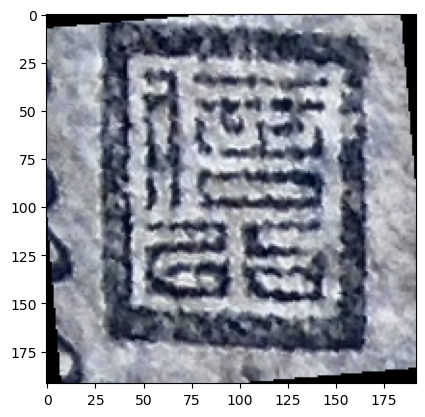

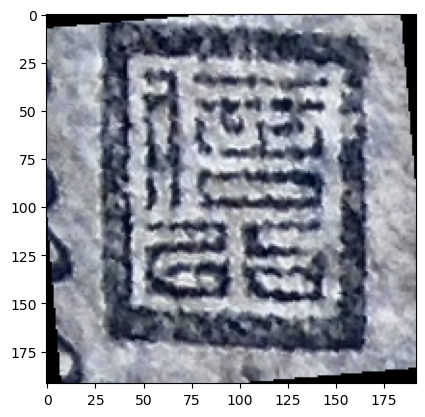

/data/tnguye28/Stamp/DCL/transforms/functional.py:70: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


torch.Size([1, 3, 192, 192])
torch.Size([1, 3, 192, 192])


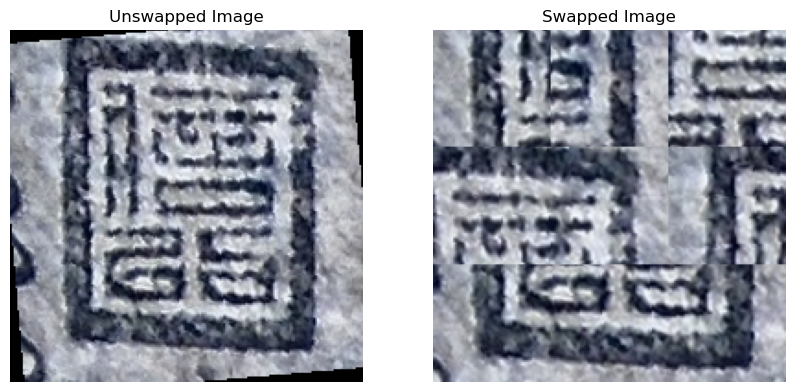

Original Label: 42
Swapped Label: -1
Image Path: ('N°419 2a_0.jpg',)


In [5]:
dataloader = DataLoader(train_set, batch_size=1, shuffle=True)
def unnormalize(image_tensor, mean, std):
    """
    Reverse the normalization process.
    Args:
        image_tensor: The normalized image tensor (C, H, W).
        mean: List of mean values for each channel.
        std: List of std values for each channel.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image_tensor * std + mean
# Function to convert tensor to image and display it
def imshow(image_tensor, title=None):
    image = image_tensor.squeeze(0)  # Remove batch dimension if present
    image = unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Unnormalize

    image = image.permute(1, 2, 0)  # Change the order of dimensions from (C, H, W) to (H, W, C)
    image = image.numpy()  # Convert to numpy for matplotlib
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')  # Hide axes for better visualization

# Get a sample from the dataset
for batch in dataloader:
    img_unswap, img_swap, label, label_swap, swap_law1, swap_law2, img_path = batch
    print(img_unswap.shape)
    print(img_swap.shape)
    # Show unswapped image
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
    imshow(img_unswap[0], title="Unswapped Image")

    # Show swapped image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
    imshow(img_swap[0], title="Swapped Image")

    plt.show()

    # Optionally print out other details like labels
    print(f"Original Label: {label.item()}")
    print(f"Swapped Label: {label_swap.item()}")
    print(f"Image Path: {img_path}")
    
    break  # Display only one sample for now